In [1]:
import os
from os import path
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
if not 'BASE_DIR' in locals():
    BASE_DIR = os.path.abspath(os.curdir)

In [2]:
if os.path.abspath(os.curdir) == BASE_DIR:
    os.chdir('../')

dirname = os.path.abspath(os.curdir) + r'\data'
df = pd.read_csv(path.join(os.sep, dirname, 'Annual rainfall in Nottingham castle 1867  1939.csv'))
df = df.drop('Unnamed: 0', axis=1)
df.head()

,x
0,29.90
1,25.33
2,27.75
3,17.93
4,26.83


In [3]:
def Fuller(name:str, df:pd.DataFrame):
    alpha = 0.05
    if hasattr(df, 'columns'):
        df = df[df.columns[0]]
    print(f'Тест Дики-Фуллера ряда {name} :')
    # определяем результат значения теста из библиотеки с учетом
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")
Fuller('Rainfall', df)

Тест Дики-Фуллера ряда Rainfall :
Test Statistic                 -3.383976
p-value                         0.011517
#Lags Used                      2.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [4]:
df['MA_window_3'] = df['x'].rolling(window=3).mean()
df

,x,MA_window_3
0,29.90,NaN
1,25.33,NaN
2,27.75,27.660000
3,17.93,23.670000
4,26.83,24.170000
...,...,...
68,26.81,22.256667
69,23.32,23.423333
70,24.29,24.806667
71,20.38,22.663333


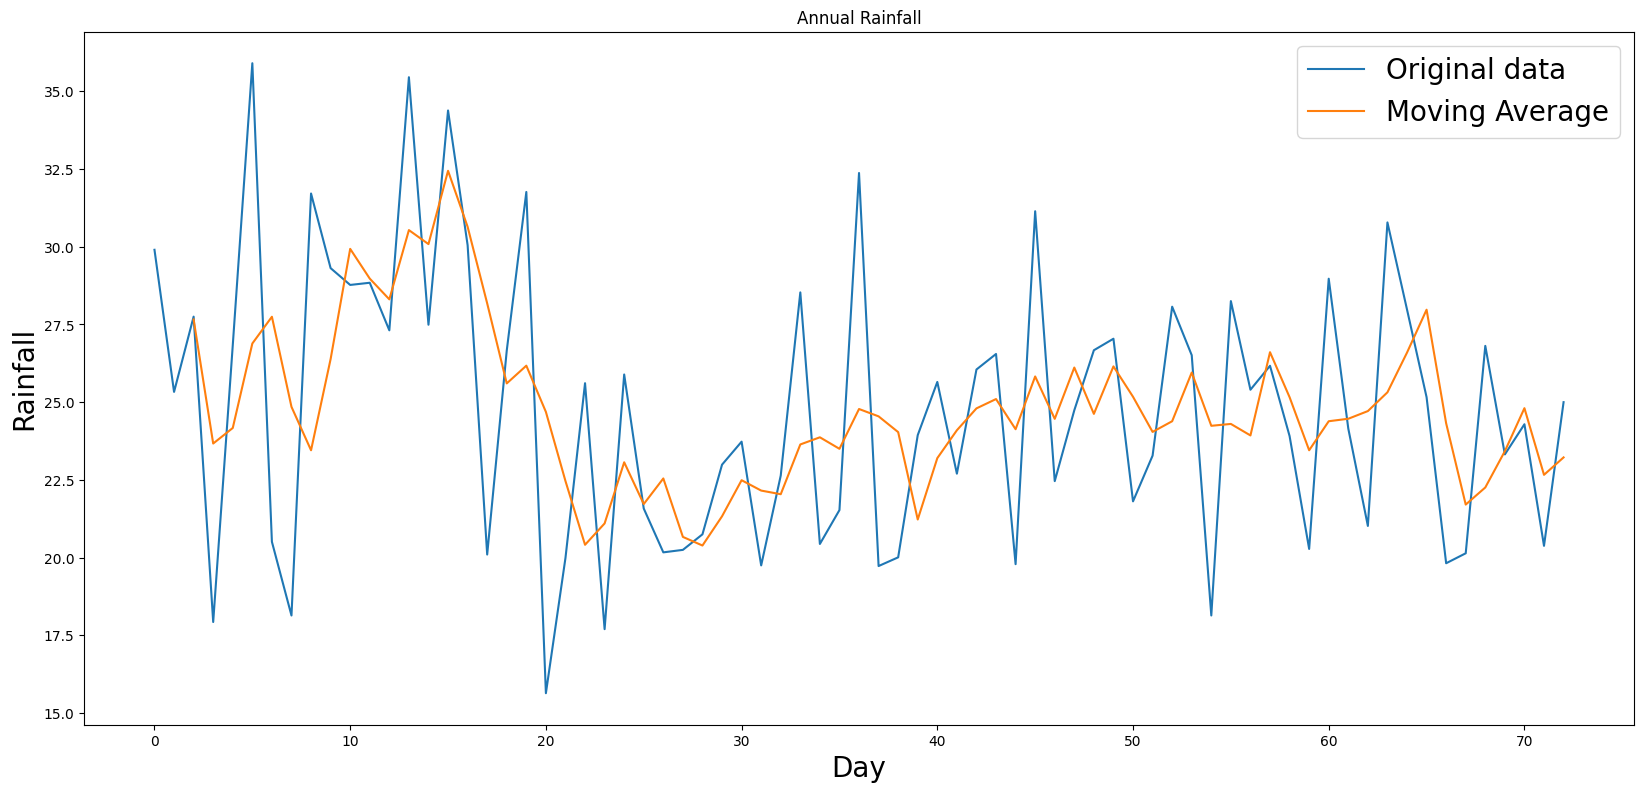

In [5]:
fig = plt.figure(figsize=(20, 9))
plt.plot(df['x'], label='Original data')
plt.plot(df['MA_window_3'], label='Moving Average')
plt.legend(fontsize="20")
plt.title('Annual Rainfall')
plt.ylabel('Rainfall', fontsize="20")
plt.xlabel('Day', fontsize="20")
plt.show()

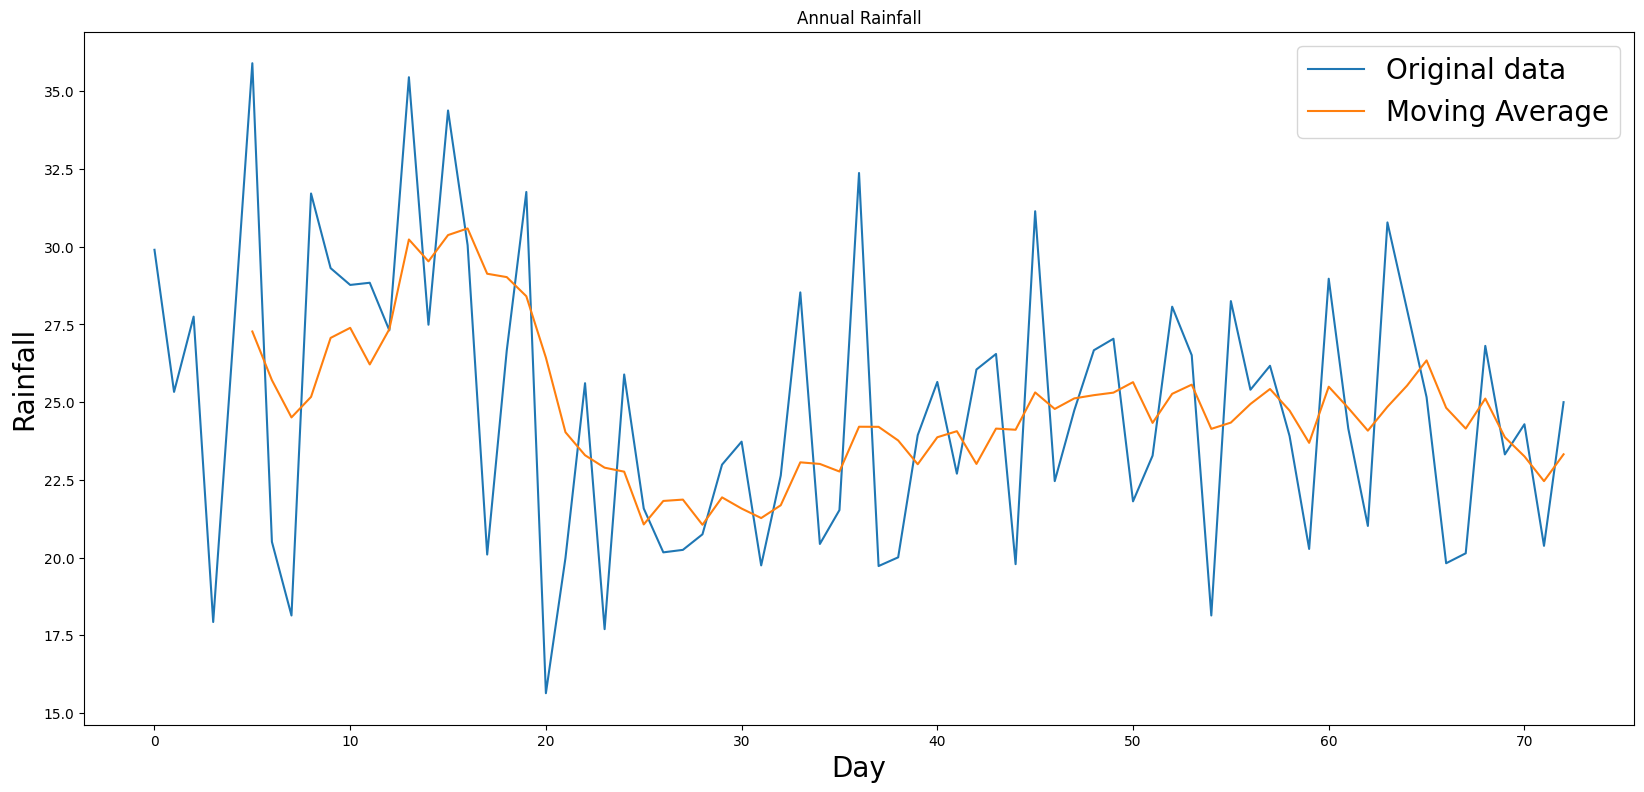

In [6]:
df['MA_window_6'] = df['x'].rolling(window=6).mean()
fig = plt.figure(figsize=(20, 9))
plt.plot(df['x'], label='Original data')
plt.plot(df['MA_window_6'], label='Moving Average')
plt.legend(fontsize="20")
plt.title('Annual Rainfall')
plt.ylabel('Rainfall', fontsize="20")
plt.xlabel('Day', fontsize="20")
plt.show()

In [7]:
from statsmodels.tsa.arima.model import ARIMA

In [8]:
arima_model = ARIMA(df['x'], order=(4,2,1))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

C:\Users\leous\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                   73
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -204.698
Date:                Fri, 01 Mar 2024   AIC                            421.396
Time:                        10:10:40   BIC                            434.972
Sample:                             0   HQIC                           426.795
                                 - 73                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9615      0.121     -7.936      0.000      -1.199      -0.724
ar.L2         -1.0459      0.180     -5.822      0.000      -1.398      -0.694
ar.L3         -0.5185      0.177     -2.931      0.0

####

In [9]:
X = df['x'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
arma_predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(4,2,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arma_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

C:\Users\leous\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Размеры выборок

In [10]:
print('Обучающие данные',len(train))
print('Тренировочные данные',len(test))

Обучающие данные 48
Тренировочные данные 25


Визуализация предсказания с помощью ARIMA

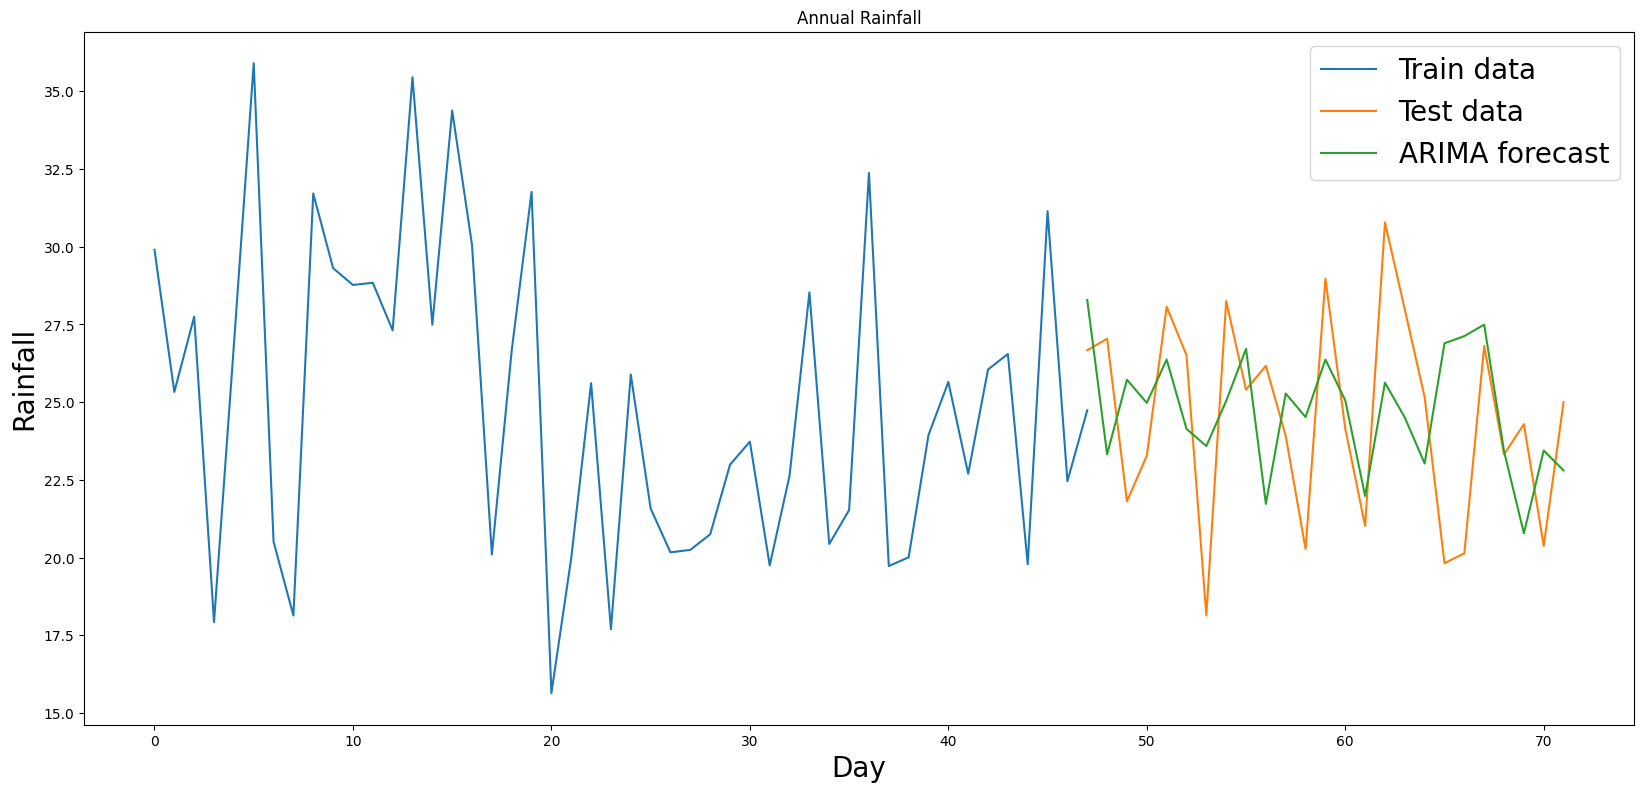

In [11]:
fig = plt.figure(figsize=(20, 9))
dur = len(arma_predictions)

plt.plot([i for i in range(0, size)], train, label='Train data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], test[:dur], label='Test data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], arma_predictions, label='ARIMA forecast')
plt.legend(fontsize="20")
plt.title('Annual Rainfall')
plt.ylabel('Rainfall', fontsize="20")
plt.xlabel('Day', fontsize="20")
plt.show()

In [12]:
def SMAPE(y_true, y_pred):
    numerator = np.abs(y_true-y_pred)
    denumerator = (np.abs(y_true) + np.abs(y_pred))/2
    res = numerator/denumerator
    res = np.sum(res)
    res *= 100
    res /= len(y_true)
    return res
def stats(df, pred):
    print("RMSE:", np.sqrt(mean_squared_error(df, pred)))
    print("MAPE:", mean_absolute_percentage_error(df, pred))
    print("MAE:", mean_absolute_error(df, pred))
    print("R2: ", r2_score(df, pred))
    print("SMAPE", SMAPE(df, pred))

Метрики

In [13]:
stats(test[:dur], arma_predictions)

RMSE: 3.474889283532644
MAPE: 0.12669624562135565
MAE: 2.9547829637640546
R2:  -0.15211139297802
SMAPE 12.21628780091537


Делаем пропуск

<Axes: >

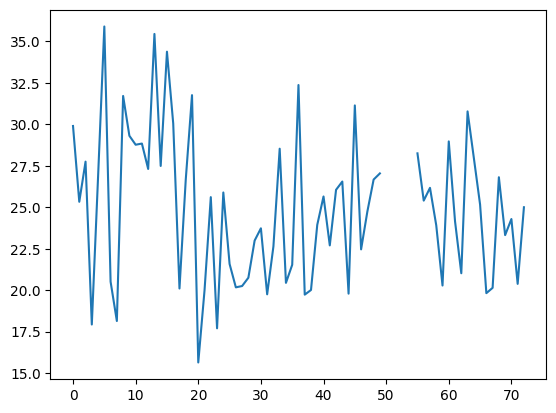

In [14]:
o_df = df.copy()

o_df["x"][50:55] = np.nan

o_df["x"].plot()

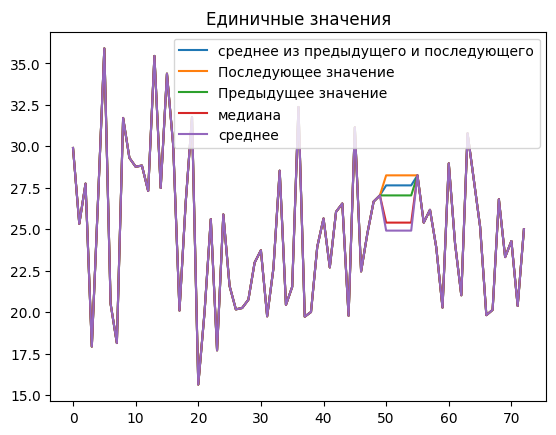

In [16]:
new_value = (o_df["x"][55] + o_df["x"][49])/2
o_df["x"][50:55] = new_value
o_df['x'].plot(label="среднее из предыдущего и последующего",)

new_value = o_df["x"][55]
o_df["x"][50:55] = new_value
o_df['x'].plot(label='Последующее значение')

new_value = o_df["x"][49]
o_df["x"][50:55] = new_value
o_df["x"].plot(label='Предыдущее значение')

new_value = o_df["x"].median()
o_df["x"][50:55] = new_value
o_df["x"].plot(label='медиана') 

new_value = o_df["x"].mean()
o_df["x"][50:55] = new_value
o_df["x"].plot(label='среднее', title="Единичные значения") 

plt.legend()
plt.show()

<Axes: title={'center': 'zero'}>

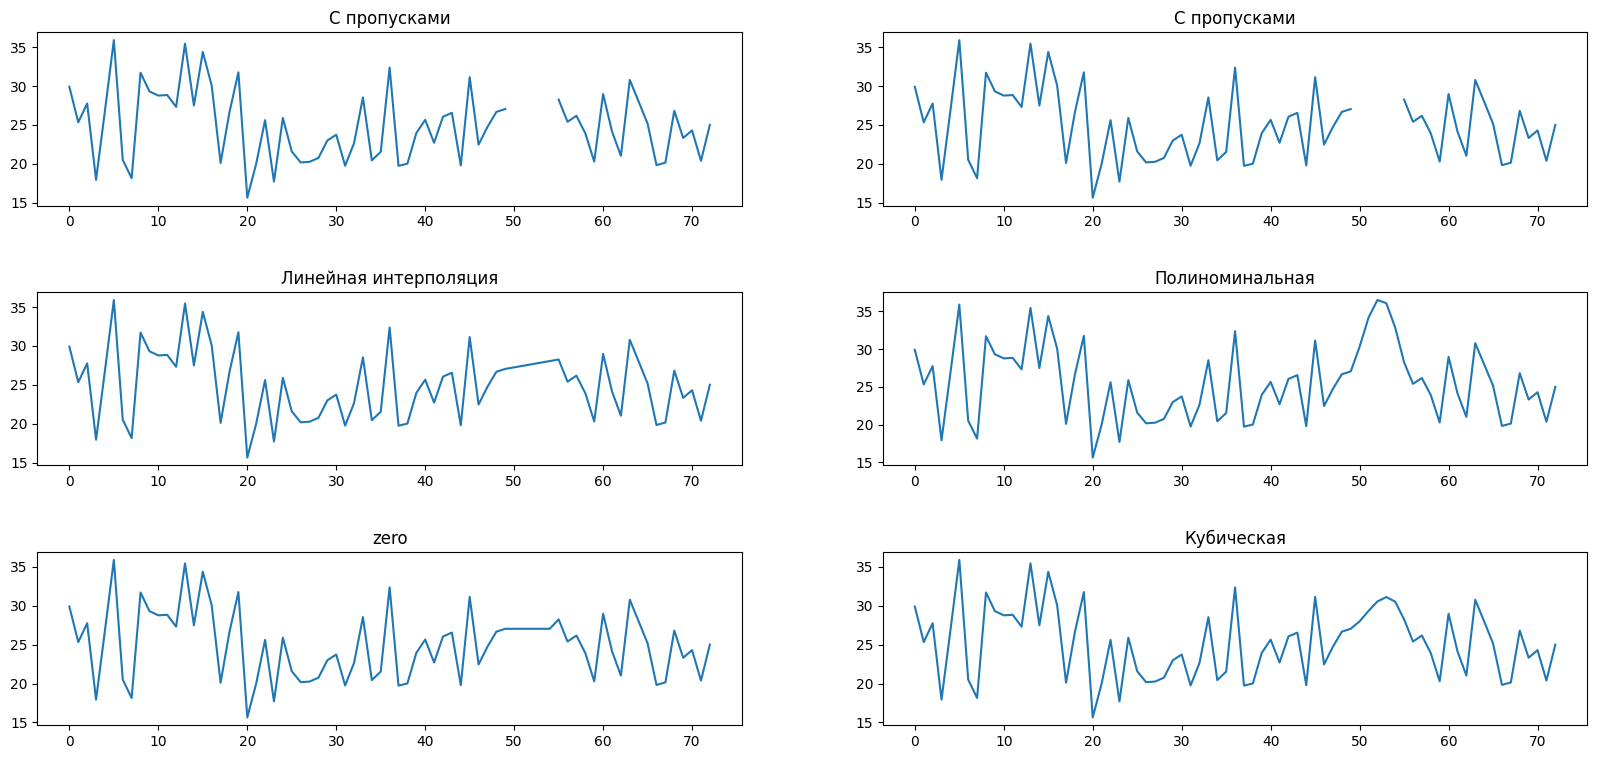

In [17]:
o_df["x"][50:55] = np.nan

lin_df = o_df.interpolate(method="linear")

cub_df = o_df.interpolate(method="cubic")

pol_df = o_df.interpolate(method="polynomial", order=5)

zero_df = o_df.interpolate(method="zero")


fig = plt.figure(figsize=(20, 9))
layout = (3, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

original_ax = plt.subplot2grid(layout, (0, 0))
lin_ax = plt.subplot2grid(layout, (1, 0))
cub_ax = plt.subplot2grid(layout, (2, 1))

pol_ax = plt.subplot2grid(layout, (1, 1))
zero_ax = plt.subplot2grid(layout, (2, 0))
 
o_df['x'].plot(title="С пропусками", ax = original_ax)  
o_df['x'].plot(title="С пропусками", ax = plt.subplot2grid(layout, (0, 1)))  
lin_df['x'].plot(title="Линейная интерполяция", ax = lin_ax) 
cub_df['x'].plot(title="Кубическая", ax = cub_ax) 
pol_df['x'].plot(title="Полиноминальная", ax = pol_ax) 
zero_df['x'].plot(title="zero", ax=zero_ax)

Ищем выбросы 

<Axes: >

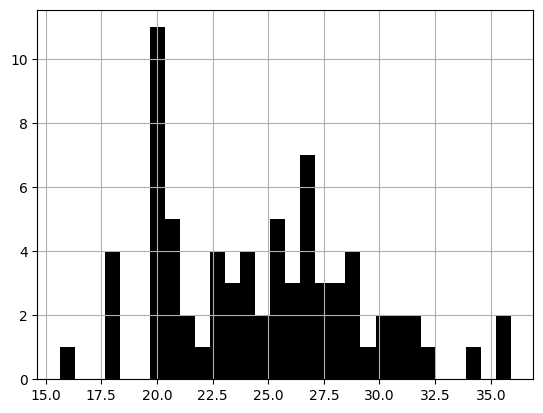

In [18]:
import seaborn as sns
df["x"].hist(bins=30, color="black")

Text(0.5, 1.0, 'Rainfall')

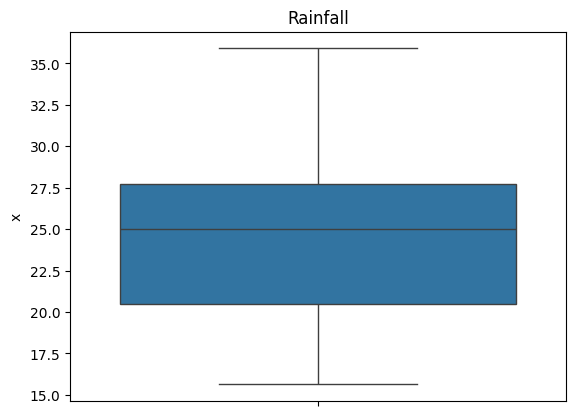

In [20]:
# fig = plt.figure(figsize=(14, 9)) 
sns.boxplot(df.x).set_title('Rainfall')

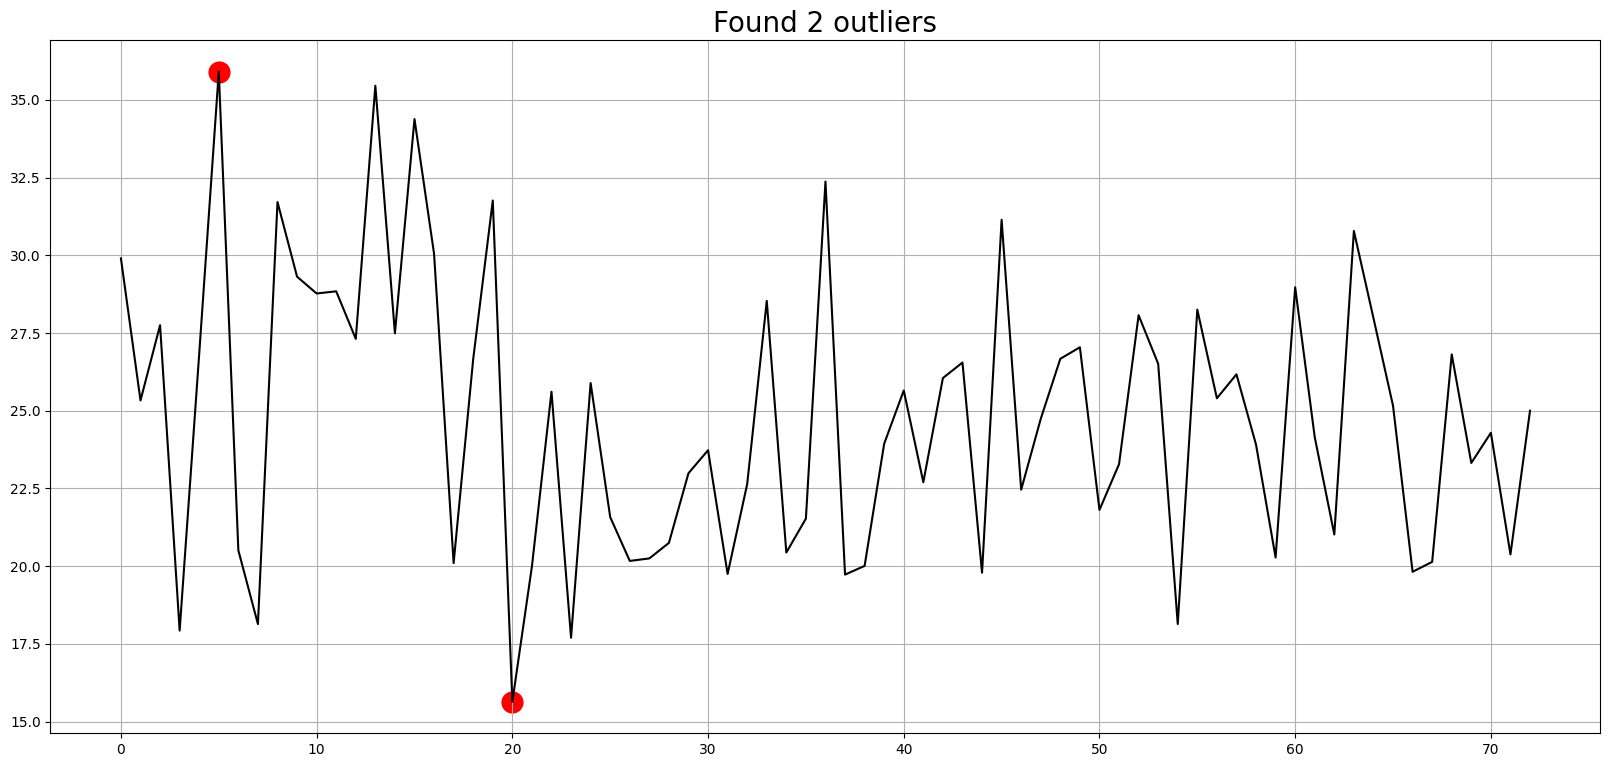

In [21]:
from sklearn import preprocessing, svm
scaler = preprocessing.StandardScaler()
perc = 0.01

local_df = df["x"]

ts_scaled = scaler.fit_transform(local_df.values.reshape(-1,1))
model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
model.fit(ts_scaled)
## dtf output
dtf_outliers =local_df.to_frame(name="ts")
dtf_outliers["index"] = range(len(local_df))
dtf_outliers["outlier"] = model.predict(ts_scaled)
dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                                            x: 1 if x==-1 else 0)
## plot
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
        color="black")
ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
           y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
           color='red', linewidths=10)
plt.title(f"Found {sum(dtf_outliers['outlier']==1)} outliers", fontdict={'fontsize': 20})
ax.grid(True)
plt.show()

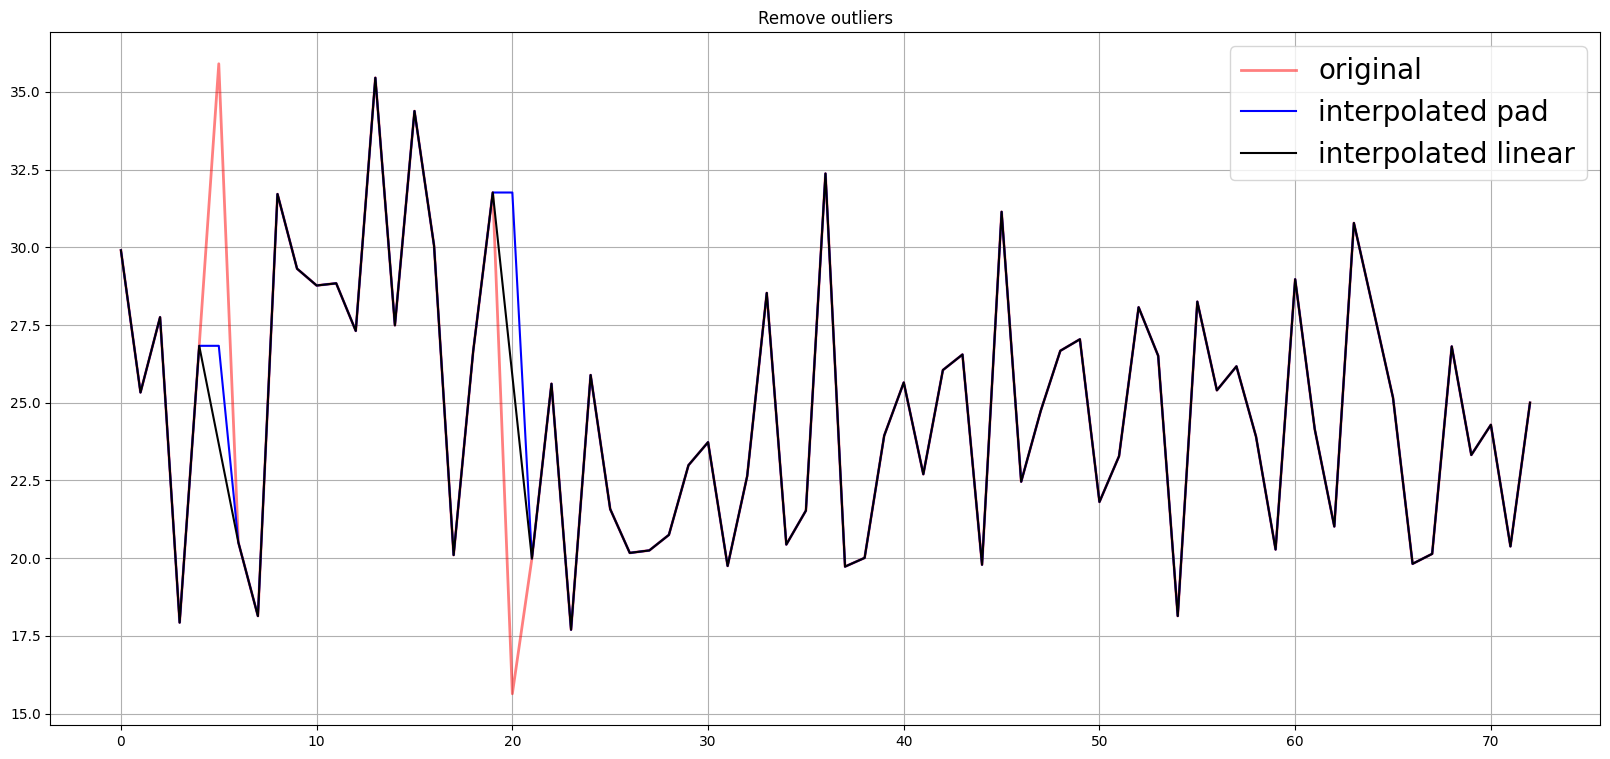

In [29]:
outliers_idx = dtf_outliers[dtf_outliers["outlier"]==1].index

ts_clean = local_df.copy()
ts_clean.loc[outliers_idx] = np.nan
ts_clean = ts_clean.interpolate(method="linear")
ax = local_df.plot(figsize=(20, 9), color="red", alpha=0.5,
             title="Remove outliers", label="original", legend=True, linewidth=2)


ts_clean1 = local_df.copy()
ts_clean1.loc[outliers_idx] = np.nan
ts_clean1 = ts_clean1.interpolate(method="pad")
# ax = local_df.plot(figsize=(20, 9), color="red", alpha=0.5,
#              title="Remove outliers", label="original", legend=True, linewidth=2)
ts_clean1.plot(ax=ax, grid=True, color="blue",
              label="interpolated pad", legend=True)
ts_clean.plot(ax=ax, grid=True, color="black",
              label="interpolated linear", legend=True)

plt.legend(fontsize="20")
plt.show()